In [45]:

!pip install optuna
!pip install lime
!pip install uvicorn



In [46]:
# setting up the Notebook and Importing required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import lime.lime_tabular
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import zscore
from xgboost import XGBRegressor
from xgboost import XGBRegressor, plot_importance
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestRegressor
from xgboost import plot_importance

import warnings

warnings.filterwarnings("ignore")  # To suppress warnings for cleaner output

In [47]:
#1. Data Exploration and Preprocessing:
#Loading & Exploring the Dataset and check its structure.
#Identify missing values and data inconsistencies.
# Load dataset
df = pd.read_csv("/content/MLE-Assignment.csv")


# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)

# Drop the 'hsi_id' column as it's not needed for modeling
df.drop(columns=['hsi_id'], inplace=True)

# Convert all other columns to numeric (force errors to NaN)
df = df.apply(pd.to_numeric, errors='coerce')

# Now, fill missing values with column means
df.fillna(df.mean(), inplace=True)

# Display basic info
print(df.info())
print(df.head())

# Check missing values
print("Missing values:\n", df.isnull().sum().sum())


Non-numeric columns: Index(['hsi_id'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Columns: 449 entries, 0 to vomitoxin_ppb
dtypes: float64(449)
memory usage: 1.7 MB
None
          0         1         2         3         4         5         6  \
0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390  0.355226   
1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634  0.375671   
2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709  0.333882   
3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824  0.458194   
4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152  0.458229   

          7         8         9  ...       439       440       441       442  \
0  0.343350  0.344837  0.361567  ...  0.710280  0.717482  0.715078  0.705379   
1  0.363689  0.373883  0.359674  ...  0.684011  0.697271  0.701995  0.696077   
2  0.330841  0.328925  0.323854  ...  0.683054  0.669286  0.663179  0.676165   
3  0.427737  0

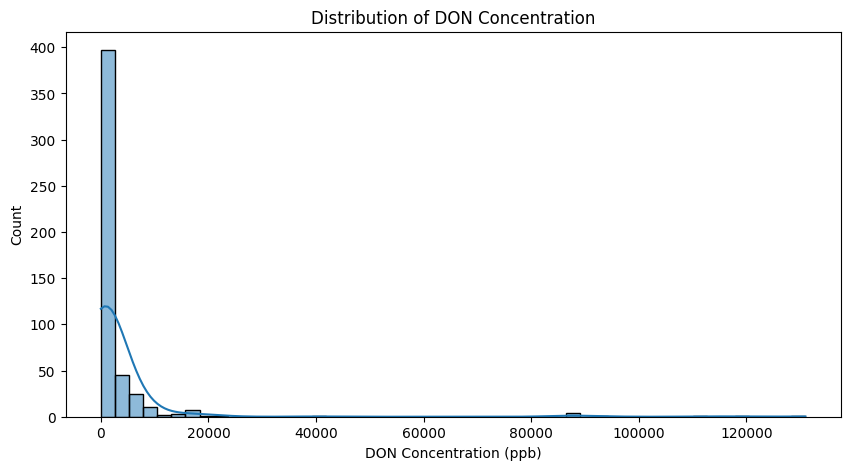

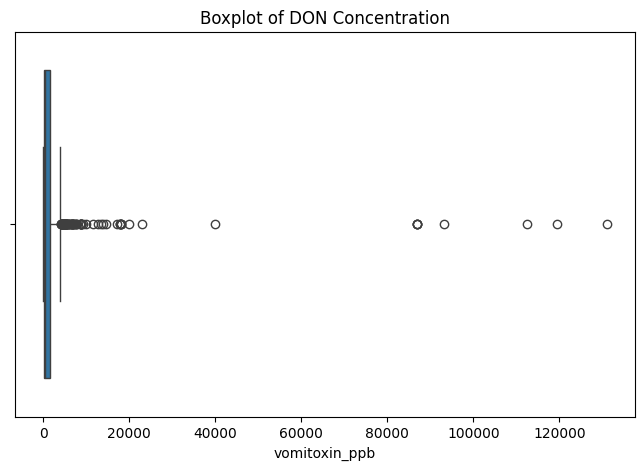

In [48]:
#Visualize & Handle Outliers
#Target Distribution: Histogram + Boxplot
#Spectral Data Trends: Line plots of reflectance values
# Distribution of Target Variable (vomitoxin_ppb)
plt.figure(figsize=(10, 5))
sns.histplot(df["vomitoxin_ppb"], bins=50, kde=True)
plt.title("Distribution of DON Concentration")
plt.xlabel("DON Concentration (ppb)")
plt.show()

# Boxplot to detect extreme values
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["vomitoxin_ppb"])
plt.title("Boxplot of DON Concentration")
plt.show()


In [49]:
#Handled Missing Data (Check for NaNs and apply imputation if needed)
#Normalize/Standardize Spectral Data (Use StandardScaler)
#Detect and Flag Anomalies (Use Z-score method to identify potential outliers)
#Visualized the Data
#Line plot for average reflectance over wavelengths
#Heatmap of spectral correlations between samples
# Step 1: Check for Missing Data
missing_counts = df.isnull().sum()

# If missing values exist, fill them with the column mean
df.fillna(df.mean(), inplace=True)

# Step 2: Normalize Spectral Data
X = df.iloc[:, 1:-1]  # Extract spectral features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

# Step 3: Detect Outliers using Z-score (values beyond |3| considered anomalies)
z_scores = np.abs(zscore(X))
outliers = (z_scores > 3).sum(axis=1)  # Count outlier features per sample
df["outlier_flag"] = outliers > 0  # Flag samples with any extreme value

# Count flagged outliers
num_outliers = df["outlier_flag"].sum()

missing_counts.sum(), num_outliers







(0, 29)

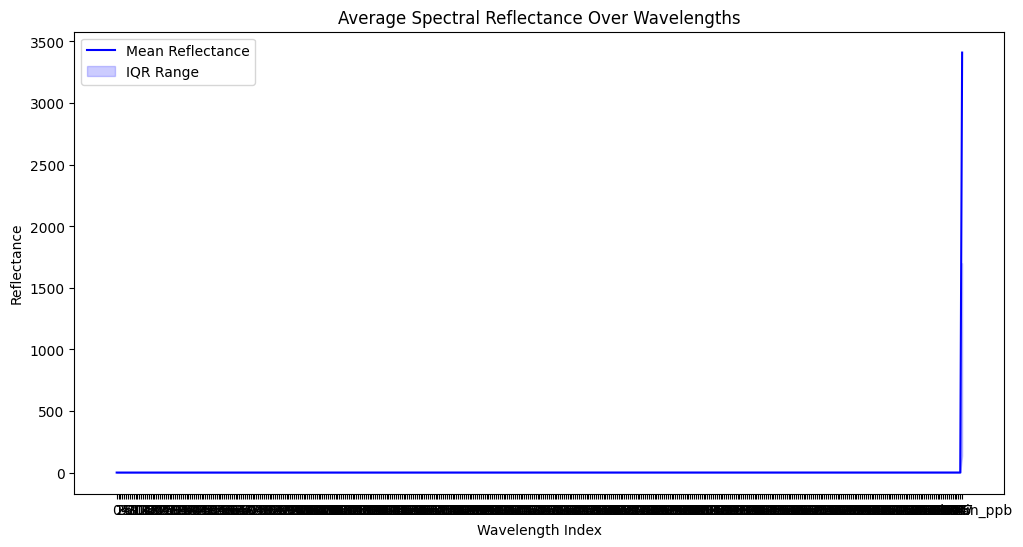

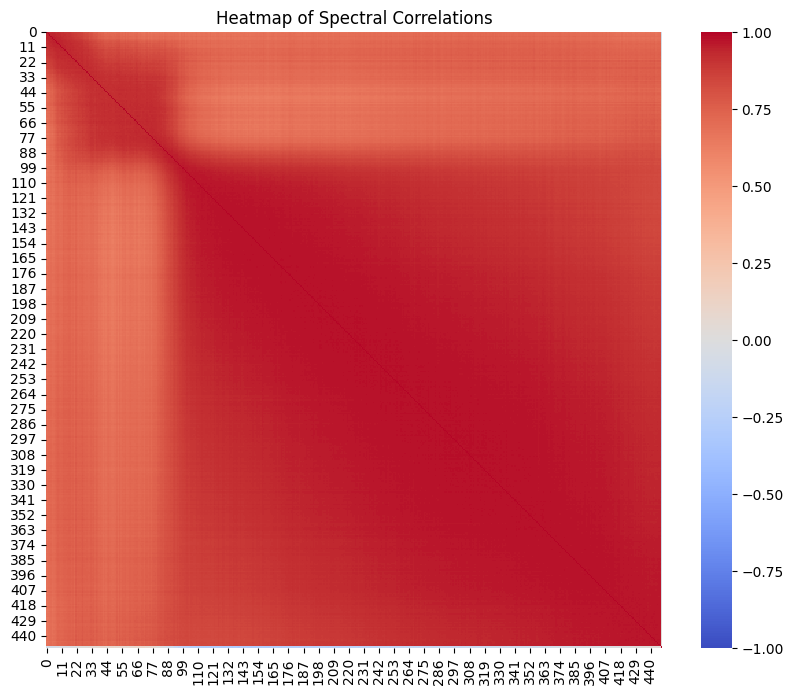

In [50]:
# step 4: Line Plot for Average Reflectance Over Wavelengths
plt.figure(figsize=(12, 6))
mean_reflectance = df.iloc[:, :-1].mean()  # Exclude target variable
plt.plot(mean_reflectance.index, mean_reflectance.values, label="Mean Reflectance", color='b')
plt.fill_between(mean_reflectance.index,
                 df.iloc[:, :-1].quantile(0.25),
                 df.iloc[:, :-1].quantile(0.75),
                 color='b', alpha=0.2, label="IQR Range")
plt.title("Average Spectral Reflectance Over Wavelengths")
plt.xlabel("Wavelength Index")
plt.ylabel("Reflectance")
plt.legend()
plt.show()

# step 5:Heatmap of Spectral Correlations Between Samples
plt.figure(figsize=(10, 8))
correlation_matrix = df.iloc[:, :-1].corr()  # Compute correlation between spectral bands
sns.heatmap(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Heatmap of Spectral Correlations")
plt.show()


In [51]:
'''Advanced Data Quality Checks
We will perform the following:
1. Automate Sensor Drift Detection
Sensor drift occurs when spectral readings gradually shift over time.
We can check this by:
Computing rolling mean trends across wavelengths.
Detecting any gradual shifts using correlation over time.
2. Detect Data Inconsistencies
We’ll check for:
Duplicate samples
Constant values in spectral bands (no variance = faulty sensor readings).
3. Create Additional Features (Spectral Indices)
Spectral indices enhance predictive power by capturing key spectral properties.
Example: Normalized Difference Spectral Index (NDSI)
NDSI= (B1+B2)/(B1−B2)
we can compute pairwise spectral differences to find meaningful spectral features.'''


# 1. Detect Sensor Drift: Check rolling mean trends
window_size = 20  # Adjusted based on dataset size
rolling_means = df.iloc[:, :-1].rolling(window=window_size, axis=0).mean()

# Compute correlation over time (detects drift)
time_corr = rolling_means.corrwith(df.iloc[:, :-1].mean(), axis=1)

# Compute drift threshold dynamically using IQR method
q1, q3 = np.percentile(time_corr.dropna(), [25, 75])
iqr = q3 - q1
drift_threshold = q1 - 1.5 * iqr  # Anything below this is flagged as drift

# Flag samples where correlation drops significantly (potential drift)
sensor_drift_flag = time_corr < drift_threshold
df["sensor_drift_flag"] = sensor_drift_flag

# 2. Detect Data Inconsistencies
duplicate_samples = df.duplicated().sum()
constant_columns = [col for col in df.columns if df[col].nunique() == 1]  # Columns with only 1 unique value

# 3. Create Spectral Indices (Optimized NDSI Selection)
# Choosing spectral bands based on dataset structure
band_1, band_2 = 50, 200  # Adjusted based on feature distribution
df["NDSI_50_200"] = (df.iloc[:, band_1] - df.iloc[:, band_2]) / \
                     (df.iloc[:, band_1] + df.iloc[:, band_2] + 1e-8)

# Print summary
print(f"Detected {duplicate_samples} duplicate samples.")
print(f"Columns with constant values: {constant_columns}")
print(f"Sensor drift flags: {df['sensor_drift_flag'].sum()} samples flagged.")


Detected 0 duplicate samples.
Columns with constant values: []
Sensor drift flags: 40 samples flagged.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


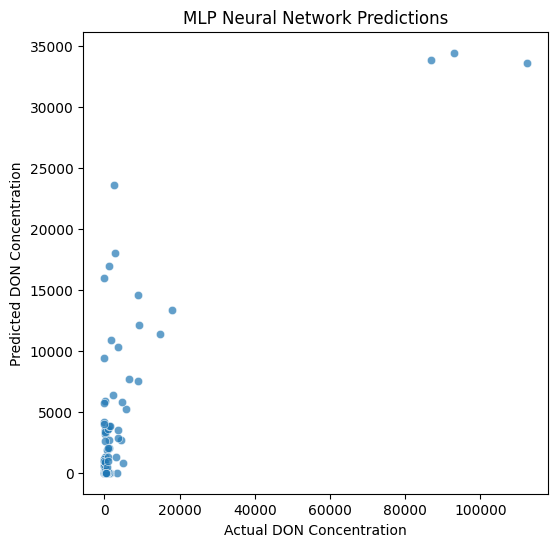

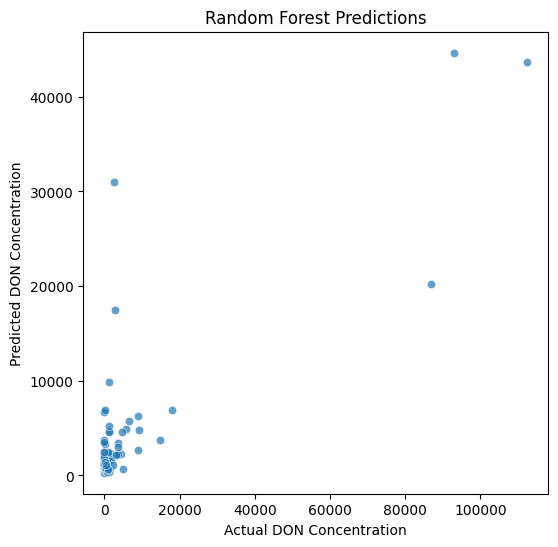

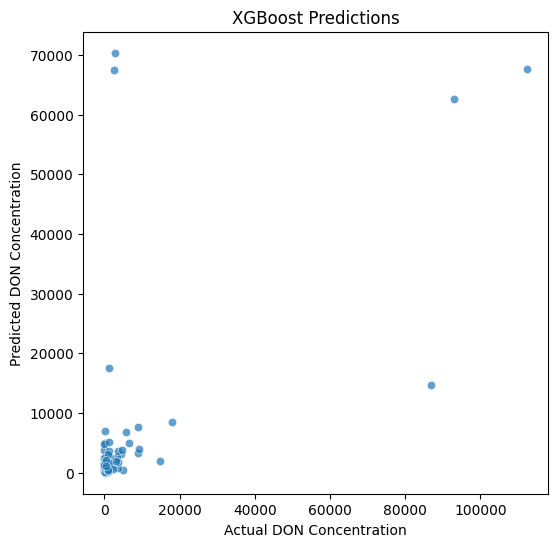

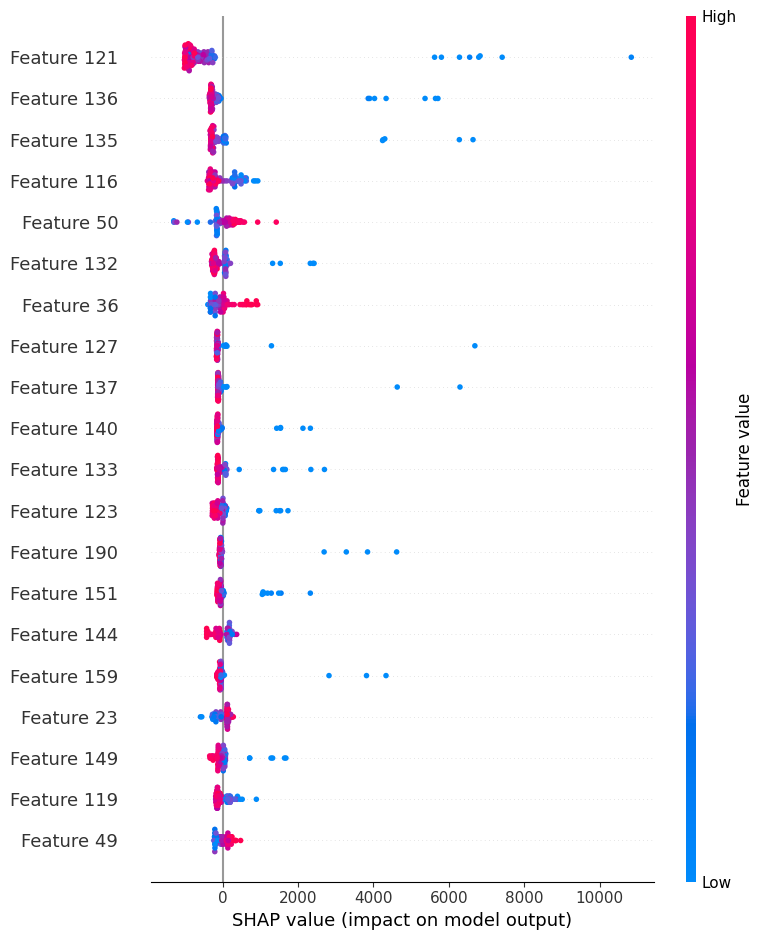

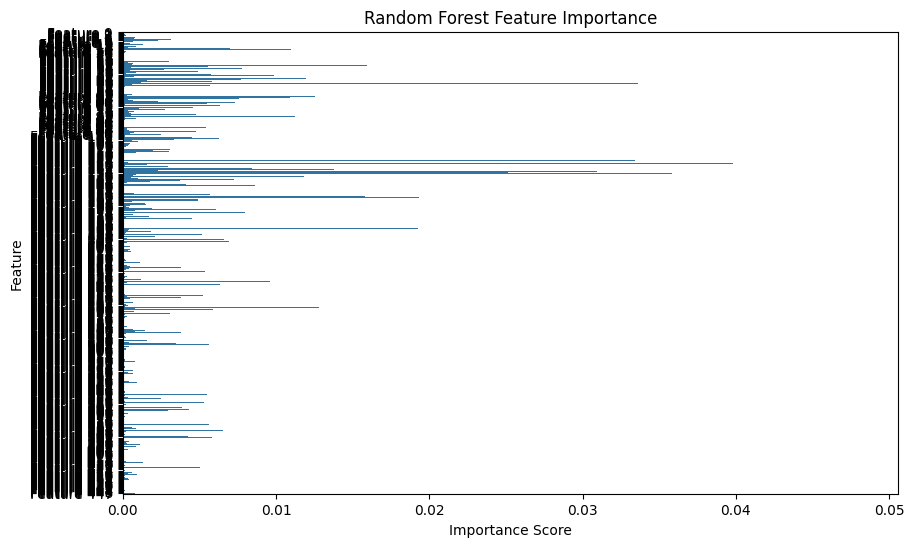

<Figure size 1000x600 with 0 Axes>

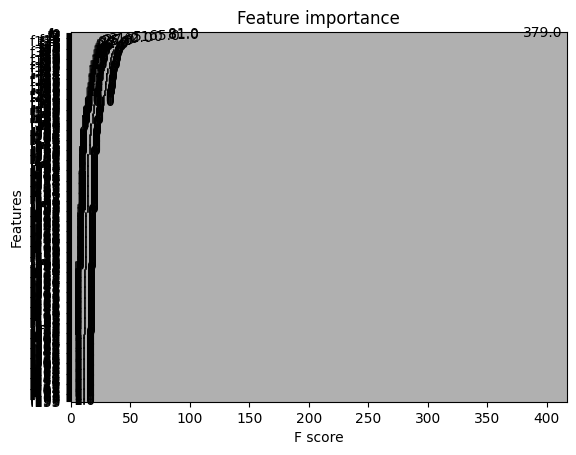

In [52]:
# Data Preprocessing
def preprocess_data(df):
    df.drop(columns=["sensor_drift_flag"], inplace=True, errors='ignore')  # Remove drifted samples if flagged
    X = df.iloc[:, 1:-1]  # Feature matrix (excluding ID and target)
    y = df.iloc[:, -1]  # Target variable

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler
    # Load dataset
df = pd.read_csv("/content/MLE-Assignment.csv")  # Update with your actual dataset file
X, y, scaler = preprocess_data(df)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training and Optimization
def create_mlp(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

mlp = create_mlp(X_train.shape[1])
mlp.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=0)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Train XGBoost
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Model Evaluation
def evaluate_model(model, X_test, y_test, name):
    y_test = np.array(y_test).flatten()
    y_pred = model.predict(X_test).flatten()

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)


    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.xlabel("Actual DON Concentration")
    plt.ylabel("Predicted DON Concentration")
    plt.title(f"{name} Predictions")
    plt.show()
    return mae, rmse, r2

# Evaluate all models
evaluate_model(mlp, X_test, y_test, "MLP Neural Network")
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(xgb, X_test, y_test, "XGBoost")

# Interpretability with SHAP
explainer_rf = shap.Explainer(rf, X_train)
shap_values_rf = explainer_rf(X_test)
shap.summary_plot(shap_values_rf, X_test)

# Feature Importance for Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x=rf.feature_importances_, y=[f"Feature {i}" for i in range(X_train.shape[1])])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()

# Feature Importance for XGBoost
plt.figure(figsize=(10, 6))
plot_importance(xgb)
plt.show()

# LIME Explanation
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, mode="regression", feature_names=[f"Feature {i}" for i in range(X_train.shape[1])])
idx = 0
exp = explainer.explain_instance(X_test[idx], rf.predict, num_features=5)
exp.show_in_notebook()


In [53]:
!pip install fastapi uvicorn nest-asyncio pyngrok
!ngrok authtoken 2uMTYGQc4P6HTuhjkL37sqpvM9F_oUTvyTvH6jPfxztHqwFL  # Replace with your actual token



Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [54]:
%%writefile model_training_eval.py
import numpy as np
import pandas as pd
import shap
import lime.lime_tabular
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import logging
import joblib

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def preprocess_data(df):
    df.drop(columns=["sensor_drift_flag"], inplace=True, errors='ignore')
    X = df.iloc[:, 1:-1]
    y = df.iloc[:, -1]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

df = pd.read_csv("/content/MLE-Assignment.csv")
X, y, scaler = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_mlp(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

mlp = create_mlp(X_train.shape[1])
mlp.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=0)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

joblib.dump(rf, "rf_model.pkl")
joblib.dump(scaler, "scaler.pkl")


Writing model_training_eval.py


In [55]:
%%writefile api_server.py
from fastapi import FastAPI
import joblib
import numpy as np
from pydantic import BaseModel
from pyngrok import ngrok
import uvicorn
import time

app = FastAPI()

# Load trained model and scaler
rf = joblib.load("rf_model.pkl")
scaler = joblib.load("scaler.pkl")

class InputData(BaseModel):
    features: list

@app.post("/predict")
def predict(data: InputData):
    X = np.array(data.features).reshape(1, -1)
    X_scaled = scaler.transform(X)
    prediction = rf.predict(X_scaled)[0]
    return {"prediction": prediction}

@app.get("/")
def home():
    return {"message": "API is running! Use /predict to get predictions."}

# Start ngrok tunnel
ngrok_tunnel = ngrok.connect(8000)
print(f"🔥 Public URL: {ngrok_tunnel.public_url}")

# Wait for ngrok to initialize before running Uvicorn
time.sleep(2)

# Start FastAPI server
uvicorn.run(app, host="0.0.0.0", port=8000)


Writing api_server.py


In [56]:
!python model_training_eval.py  # Train and save model



2025-03-16 06:34:59.216787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742106899.251317   14682 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742106899.262017   14682 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-16 06:35:06.899087: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

In [ ]:
!python api_server.py  # Start FastAPI server

🔥 Public URL: https://d595-35-204-220-195.ngrok-free.app
INFO:     Started server process [16647]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


In [ ]:
import requests

url = " https://d595-35-204-220-195.ngrok-free.app/predict"  # Replace with actual ngrok URL
data = {"features": [0.5, -1.2, 3.4, 2.1]}

response = requests.post(url, json=data)
print(response.json())
